In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
from collections import defaultdict, Counter

# Load a smaller model to avoid memory issues
model_id = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float32)
model.config.output_hidden_states = True
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

c:\Users\carol\anaconda3\envs\drl\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\carol\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [10]:
# Ring graph of concept tokens
tokens = ['apple', 'car', 'dog', 'moon', 'cat', 'sun', 'fig', 'bird', 'plane']
G = nx.cycle_graph(tokens)

# Generate prompt via random walk
def random_walk(graph, length):
    node = random.choice(list(graph.nodes()))
    sequence = [node]
    for _ in range(length - 1):
        node = random.choice(list(graph.neighbors(node)))
        sequence.append(node)
    return sequence

sequence = random_walk(G, length=1000)
prompt = ' ' + ' '.join(sequence)
token_freq = Counter(sequence)

# Tokenise and run model
inputs = tokenizer(prompt, return_tensors='pt').to(device)
with torch.no_grad():
    outputs = model(**inputs)
hidden_states = outputs.hidden_states

# Convert token IDs to strings
token_indices = inputs['input_ids'][0]
token_strings = tokenizer.convert_ids_to_tokens(token_indices.tolist())

# Group hidden states for each concept
layer_ids = [0, len(hidden_states) // 2, -1]  # Early, middle, final layers
concept_activations = {layer: defaultdict(list) for layer in layer_ids}

for layer in layer_ids:
    for i, token in enumerate(token_strings):
        for concept in tokens:
            if token.endswith(concept):
                vec = hidden_states[layer][0, i].detach().cpu().numpy()
                concept_activations[layer][concept].append(vec)



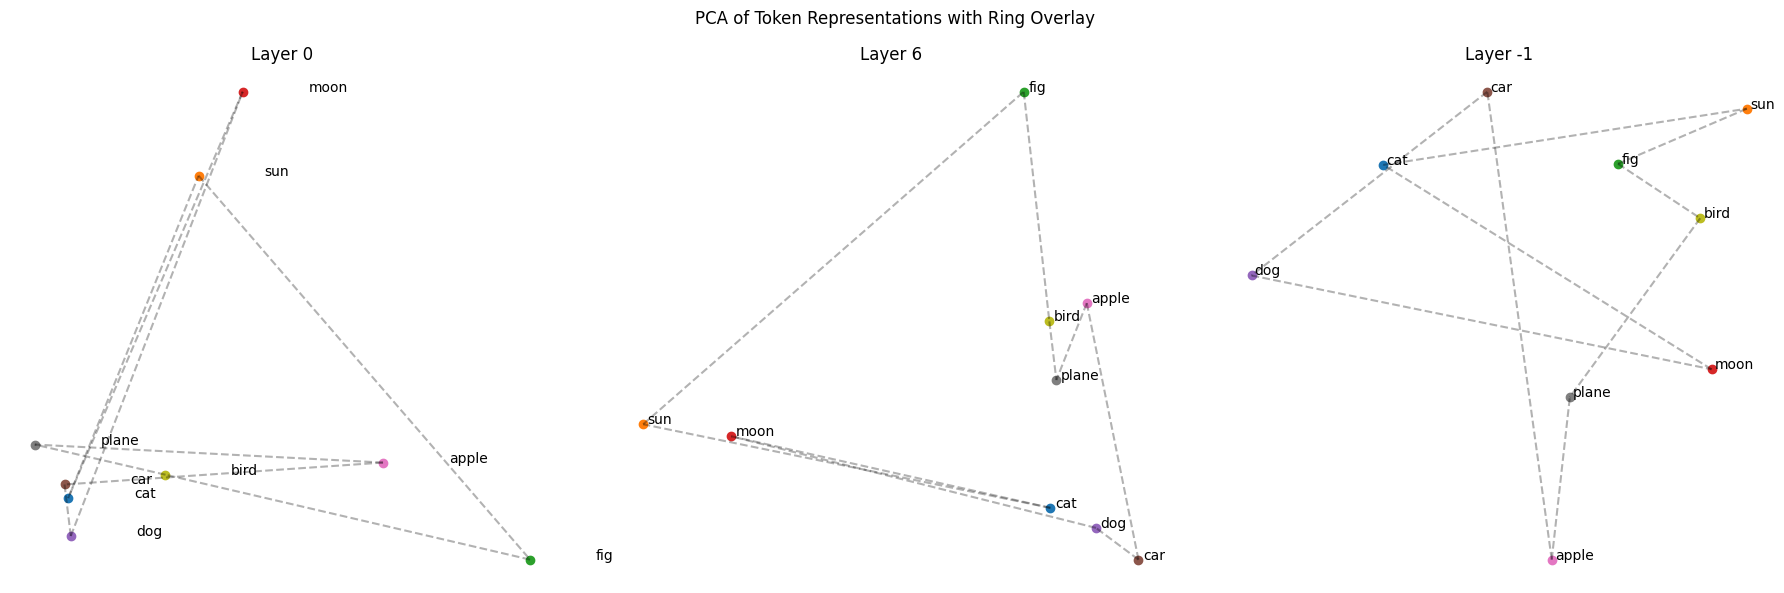

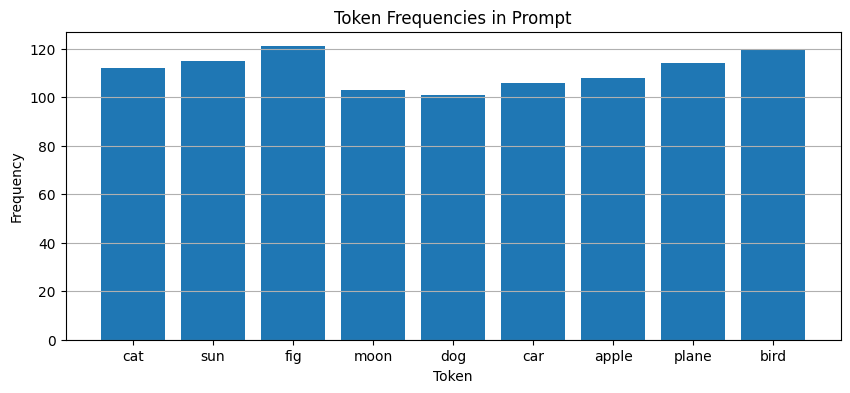

In [11]:
# Compute mean representation per concept per layer
mean_reps = {
    layer: {c: np.mean(v, axis=0) for c, v in vecs.items()}
    for layer, vecs in concept_activations.items()
}

# PCA plots with ring overlay
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, layer in zip(axs, layer_ids):
    concepts = list(mean_reps[layer].keys())
    X = np.array([mean_reps[layer][c] for c in concepts])
    X_pca = PCA(n_components=2).fit_transform(X)
    coords = {c: X_pca[i] for i, c in enumerate(concepts)}

    for c, (x, y) in coords.items():
        ax.scatter(x, y)
        ax.text(x + 0.5, y, c, fontsize=10)

    for a, b in G.edges():
        if a in coords and b in coords:
            ax.plot([coords[a][0], coords[b][0]], [coords[a][1], coords[b][1]], 'k--', alpha=0.3)

    ax.set_title(f"Layer {layer}")
    ax.axis('off')

plt.suptitle("PCA of Token Representations with Ring Overlay")
plt.tight_layout()
plt.show()

# Plot token frequency in prompt
plt.figure(figsize=(10, 4))
plt.bar(token_freq.keys(), token_freq.values())
plt.title("Token Frequencies in Prompt")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()
